# 1 Knapsack Problem

The knapsack problem is one of the most trivial NP-hard problems. We can encounter many of its variants in the literature, which generally have various solution requirements for the algorithm. The formulation always contains criterium for the overall price, which means it is an optimization problem.

## 1.1 Author of Report

* **Name:** Tomáš Patro
* **Username:** patrotom
* **Email:** patrotom@fit.cvut.cz

## 1.2 Base of Problem

We are given

* integer $n$ (number of items)
* integer $M$ (capacity of knapsack)
* finite set $V = \{v_1, v_2, \dots, v_n\}$ (weights of items)
* finite set $C = \{c_1, c_2, \dots, c_n\}$ (prices of items)

## 1.3 Construction 0/1 Problem Form

The most well-known is the construction form. If we talk about the “knapsack problem” without a further description, we usually mean this version:

Construct the set $X = \{x_1, x_2, \dots, x_n\}$ where each $x_i$ is either $0$ or $1$, so $$v_1x_1 + v_2x_2 + \dots + v_nx_n \leq M \text{(knapsack is not overloaded)}$$ and expression $$c_1x_1 + c_2x_2 + \dots + c_nx_n$$ gains maximal value for all given sets (value of the items in the knapsack is maximal).

<br>

*(“B201-NI-KOP: Problém Batohu (Knapsack Problem)” 2020)*

# 2 Solution approaches

In the following section, we will describe approaches (algorithms) to solve the given problem:

* Brute force
* Branch and bound (B&B)
* Greedy heuristic
* Redux heuristic
* Dynamic programming (decomposition by weight)

Brute force, B&B, and dynamic programming algorithms find the optimal price. Greedy, and redux algorithms may not find the optimal price, and we track the relative error of the computation. We compare the found price with the optimal price computed by the B&B algorithm.

## 2.1 Brute Force

In the brute force approach, we search the whole state space to find the optimal price and configuration.

Let us look at the code snippet of the algorithm:

``` python
def brute_force(conf, i, weight, price):
    if i == instance.size:
        if price >= solution.price and weight <= instance.capacity:
            solution.price = price
            solution.conf = conf
        return

    new_weight = instance.items[i].weight + weight
    new_price = instance.items[i].price + price

    conf[i] = 1
    brute_force(conf, i + 1, new_weight, new_price)

    conf[i] = 0
    brute_force(conf, i + 1, weight, price)
```

The algorithm starts by comparing the current depth of the recursion `i` with the size of the instance. We use to comparison to determine if we have already solved one of the branches of recursion. If the `price` is greater or equal to the current optimal price and the `weight` is less than or equal to the knapsack capacity, we update the `solution` object with the new values – `price` and vector configuration `conf`.

Next, we compute a new weight by adding the current weight to the particular items' weight. To cover the whole state space, we have to call the recursion with the current bit set to either $0$ or $1$. We also have to recalculate the price and weight. We later send them the recursion if the bit is set to $1$ – it means that the item is added to the knapsack. In this way, we construct the whole state space and find the optimal solution.

## 2.2 Branch and Bound (B&B)

The beginning of the B&B algorithm is the same as in the brute force algorithm. The only difference is in the condition we use for the cutting of the recursion calls (state space). Let us take a look at the difference in the algorithm:

``` python
def branch_and_bound(conf, i, weight, price):
    if i == instance.size:
        if price >= solution.price:
            solution.price = price
            solution.conf = conf
        return
    
    new_weight = instance.items[i].weight + weight
    new_price = instance.items[i].price + price
    upper_bound = price + instance.prices_sum(i=i)

    conf[i] = 1
    if (new_weight <= instance.capacity) and (upper_bound > solution.price):
        branch_and_bound(conf, i + 1, new_weight, new_price)

    conf[i] = 0
    branch_and_bound(conf, i + 1, weight, price)
```

We add the condition by checking if the current `price` added to the sum of prices of the unvisited items (on the index `i` and greater) is greater than the current optimal price. We also check if the `new_weight` does not overload the knapsack. We can cut the recursion branch if we do not meet this condition. This way, we cut the branches of the state space, which do not lead us to the optimal price and valid solution.

## 2.3 Greedy Heuristic

We implement a simple heuristic using the relation between the price and weight. Let us take a look at the algorithm:

``` python
def greedy():
    instance.sort_items()
    capacity = instance.capacity
    price = 0

    for item in instance.items:
        if capacity >= item.weight:
            price += item.price
            capacity -= item.weight
            solution.conf[item.index] = 1
    
    solution.price = price
```

We start by sorting the items in descending order by $price/weight$ ratio. Then we iterate the items in this order. We check if the current capacity is greater or equal to the current items' weight in each iteration. If we meet this condition, we add the items' price to the overall price and lowers the capacity by the items' weight. We also update the configuration because we know that the item will be present in the result.

## 2.4 Redux Heuristic

Since we can encounter a situation where, for example, the last item alone would give us the optimal solution, we enhance the greedy heuristic in the following fashion:

``` python
def redux():
    greedy = Greedy()
    greedy.solve()
    highest_price, index = find_highest_price()

    if greedy.solution.price > highest_price:
        solution.price = greedy.solution.price
        solution.conf = greedy.solution.conf
    else:
        solution.price = highest_price
        solution.conf[index] = 1

def find_highest_price():
    highest_price = 0
    index = -1
    for item in instance.items:
        if item.price > highest_price and item.weight <= instance.capacity:
            highest_price = item.price
            index = item.index
    
    return (highest_price, index)
```

First, we calculate the price using the greedy algorithm. Next, we find the highest price of an item that does not overload the knapsack. Then, we compare the price found by the greedy algorithm with the highest price – the solution depends on the price, which is higher.

## 2.5 Dynamic Programming (Weight Decomposition)

The subproblems are re-evaluated, and the problem has overlapping subproblems property. We can take advantage of the dynamic programming by constructing a temporary 2D array `table` in a bottom-up manner:

``` python
def dynamic_by_weight():
    capacity = instance.capacity
    size = instance.size
    table = [[0 for x in range(capacity + 1)] for x in range(size + 1)]

    for i in range(size + 1):
        for w in range(capacity + 1):
            weight = instance.items[i - 1].weight
            price = instance.items[i - 1].price

            if i == 0 or w == 0:
                table[i][w] = 0
            elif weight <= w:
                table[i][w] = max(
                    price + table[i - 1][w - weight],
                    table[i - 1][w]
                )
            else:
                table[i][w] = table[i - 1][w]

    solution.price = table[size][capacity]
    solution.conf = construct_conf(capacity)

def construct_conf():
    conf = []

    for i in range(instance.size, 0, -1):
        if table[i][capacity] == table[i - 1][capacity]:
            conf.append(0)
        else:
            conf.append(1)
            capacity -= inst.items[i - 1].weight

    conf.reverse()

    return conf
```

In this solution, we take an approach where we compare the situation where the $n$th item is in the solution and when it is not. When we compare these two situations, we determine whether the item should or should not be in the solution. We repeat this process unless we encounter trivial subproblems. This approach leads us to an optimal solution. Afterward, we iterate over the table in a backward fashion to reconstruct the optimal solution's configuration.

# 3 Experimental Evaluation of Algorithms Quality

There is a lot of different algorithms for solving the knapsack problem. However, we do not know too much about their behavior. If we want to gather information about their behavior, we have to evaluate them experimentally.

We observe two important aspects:

1. quality of the solution
2. execution time

We observe these aspects in relation to different parameters of an instance. If we put these two aspects into relation, we can figure out which algorithm is the most suitable based on the combination of the requirements on these aspects. We also observe the stability of the algorithm given a different order of the items – robustness.

We use a prepared generator of the instances *kg2*, which can be parametrized, and thus, we can observe how the algorithm behaves under different conditions. We relate to the different behavior of an algorithm as to the sensitivity of the algorithm. We assume that the different parameters do not relate to each other – we set the parameters to the constant values and always change only one parameter.

**Data analysis:**

We analyze the data using the *Python* language and its mathematical modules. The graphs and the whole report are rendered in the *Jupyter Notebook* – that's why we also add the code snippets in this report, which process data and generate the graphs.

**Execution time measuring:**

We measured the execution time for each run of an algorithm and saved the data to the prepared object. All execution times in this report were measured using the Python `timeit` module, which measures CPU time. The times you see in the following graphs are represented in **miliseconds \[ms\]**.

Computer configuration:

* **CPU:** Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz
* **OS:** Linux Mint 19.2
* **Linux kernel:** 5.4.0-48-generic

**Relative error computation:**

We observe the relative errors of both heuristics – greedy and redux. Given:

* calculated price $P$
* optimal price $O$

We calculate the relative error $\epsilon$ as: $$\epsilon = \frac{|P - O|}{max\{O, P\}}$$

We observe the relation between the average relative error $\epsilon$ on the instance size $n$ and the instance size itself. In the graphs, we show the relative error **per mille \[‰\]**. We compute the optimal price $O$ using the **B&B** algorithm.

**Generator parameters:**

* $n$ – number of items
* $N$ – number of instances
* $m$ – knapsack capacity and sum weight ratio (real number / uniform distribution interval)
* $W$ – maximum item weight
* $w$ – light/heavy items dominance
* $C$ – maximum item price
* $c$ – correlation between price and weight
* $k$ – granularity exponent

<br>

*(“B201-NI-KOP: Generátory instancí problému batohu (Knapsack problem instance generators)” 2020)*

We use these parameters values:

* $n = 20$
* $N = 100$
* $m \in \{0.01, 0.208, 0.406, 0.604, 0.802, 1.0\}$
* $W = 1000$
* $w \in \{heavy, light\}$
* $C = 5000$
* $c \in \{uni, corr, strong\}$
* $k \in \{-3, -1.8, -0.6, 0.6, 1.8, 3\}$

If we summarize it, we will observe these **aspects** of the algorithms:

1. Knapsack capacity and sum weight ratio
2. Price and weight correlation
3. Weight distribution and granularity
4. Robustness

In [1]:
import sys
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from knapsack_solver import KnapsackSolver

In [2]:
# Helper functions and configuration

plt.rcParams['figure.figsize'] = (16, 9)

# Graph config
def bar_plot(ax, data, colors=None, total_width=0.8, single_width=1, legend=True):
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    n_bars = len(data)
    bar_width = total_width / n_bars
    bars = []

    for i, (name, values) in enumerate(data.items()):
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])
            height = bar[0].get_height()
        bars.append(bar[0])

    if legend:
        ax.legend(bars, data.keys())

def graph_color(version):
    switcher = {
        "B&B": "blue",
        "Dynamic Weight": "green",
        "Greedy": "red",
        "Redux": "orange",
    }
    return switcher.get(version, "blue")

# Graphs
def m_graph(data, version, rel_err=False):
    data_pos = [i for i, _ in enumerate(data.keys())]
    plt.bar(data_pos, data.values(), color=graph_color(version))
    plt.xlabel("Capacity and sum weight ratio (m)")
    if rel_err:
        plt.title(f"Average relative error by m ({version})")
        plt.ylabel("Relative error [‰]")
    else:
        plt.title(f"Average execution time by m ({version})")
        plt.ylabel("Execution time [ms]")
    plt.xticks(data_pos, data.keys())
    return plt

def c_graph(data, version, rel_err=False):
    data_pos = [i for i, _ in enumerate(data.keys())]
    plt.bar(data_pos, data.values(), color=graph_color(version))
    plt.xlabel("Correlation between price and weight (c)")
    if rel_err:
        plt.title(f"Average relative error by c ({version})")
        plt.ylabel("Relative error [‰]")
    else:
        plt.title(f"Average execution time by c ({version})")
        plt.ylabel("Execution time [ms]")
    plt.xticks(data_pos, data.keys())
    return plt

def k_graph(data, ax, version, rel_err=False):
    labels = list(map(lambda x: "{:.1f}".format(x),np.linspace(-3, 3, 6)))
    x = np.arange(len(labels))
    ax.set_xlabel("Granularity exponent (k)")
    if rel_err:
        ax.set_title(f"Average relative error by k ({version})")
        ax.set_ylabel("Relative error [‰]")
    else:
        ax.set_title(f"Average execution time by k ({version})")
        ax.set_ylabel("Execution time [ms]")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    bar_plot(ax, data, total_width=.8, single_width=.9)

def p_graph(data, version, rel_err=False):
    data_pos = [i for i, _ in enumerate(data.keys())]
    plt.bar(data_pos, data.values(), color=graph_color(version))
    plt.xlabel("Permutation")
    if rel_err:
        plt.title(f"Average relative error by permuration ({version})")
        plt.ylabel("Relative error [‰]")
    else:
        plt.title(f"Average execution time by permuration ({version})")
        plt.ylabel("Execution time [ms]")
    plt.xticks(data_pos, data.keys())
    return plt

# Data generating
def m_gen(gen_opts, version, rel_err=False):
    gen_opts = gen_opts.copy()
    ms = np.linspace(0.01, 1.0, 6)
    data = {}
    data_r = {}
    for m in ms:
        gen_opts["m"] = m
        solver = KnapsackSolver(version, gen_opts)
        solver.run()
        data[float("{:.3f}".format(m))] = solver.time_mean()
        if rel_err:
            data_r[float("{:.3f}".format(m))] = solver.rel_err_mean()
    
    if rel_err:
        return data, data_r
    else:
        return data

def c_gen(gen_opts, version, rel_err=False):
    gen_opts = gen_opts.copy()
    cs = ["uni", "corr", "strong"]
    data = {}
    data_r = {}
    for c in cs:
        gen_opts["c"] = c
        solver = KnapsackSolver(version, gen_opts)
        solver.run()
        data[c] = solver.time_mean()
        if rel_err:
            data_r[c] = solver.rel_err_mean()

    if rel_err:
        return data, data_r
    else:
        return data

def k_gen(gen_opts, version, rel_err=False):
    gen_opts = gen_opts.copy()
    ks = np.linspace(-3, 3, 6)
    ws = ["light", "heavy"]
    data = {"light": [], "heavy": []}
    data_r = {"light": [], "heavy": []}
    for w in ws:
        gen_opts["w"] = w
        for k in ks:
            gen_opts["k"] = k
            solver = KnapsackSolver(version, gen_opts)
            solver.run()
            data[w].append(solver.time_mean())
            if rel_err:
                data_r[w].append(solver.rel_err_mean())
    
    if rel_err:
        return data, data_r
    else:
        return data

def p_gen(gen_opts, version, rel_err=False):
    gen_opts = gen_opts.copy()
    solver = KnapsackSolver(version, gen_opts)
    solver.run_perms()
    
    o_mean = solver.time_mean()
    p_means = solver.perm_time_means()
        
    data = {
        "original": o_mean,
        "perm 1": p_means[0],
        "perm 2": p_means[1],
        "perm 3": p_means[2],
        "perm 4": p_means[3],
        "perm 5": p_means[4],
    }
    
    if rel_err:
        o_mean = solver.rel_err_mean()
        p_means = solver.perm_rel_err_means()
        data_r = {
            "original": o_mean,
            "perm 1": p_means[0],
            "perm 2": p_means[1],
            "perm 3": p_means[2],
            "perm 4": p_means[3],
            "perm 5": p_means[4],
        }
        return data, data_r
    else:
        return data

In [3]:
gen_opts = {
    "n": 20,
    "N": 100,
    "W": 1000,
    "C": 5000,
}

## 3.1 Brute Force

Since our version of the brute force algorithm searches the whole state space, there is no need to analyze its behavior. The brute force algorithm always behaves in the same way, no matter the combination of parameters we use to generate the instances.

You can find a description of the algorithm in **section 2.1**.

## 3.2 Branch and Bound (B&B)

You can find a description of the algorithm in **section 2.2**.

### 3.2.1 Knapsack Capacity and Sum Weight Ratio

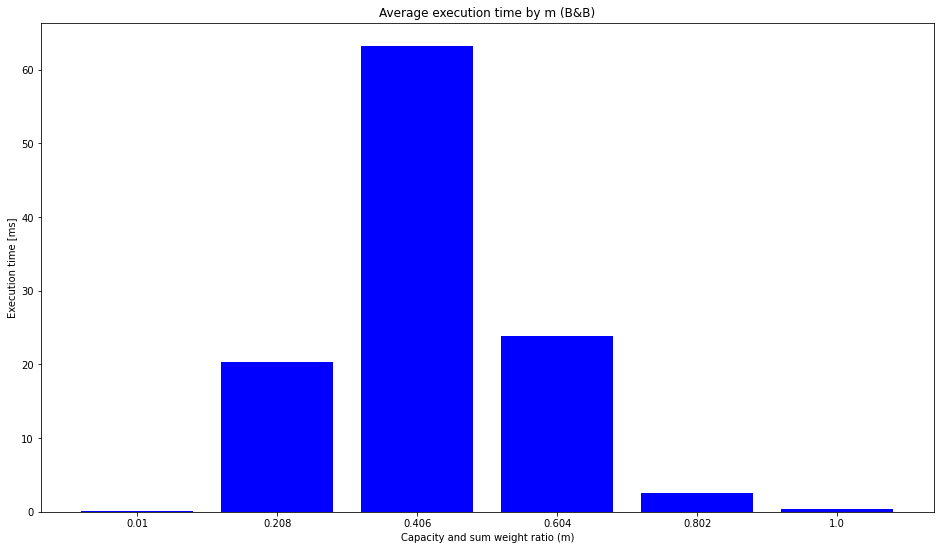

In [4]:
m_data = m_gen(gen_opts, "bb")
plt = m_graph(m_data, "B&B")
plt.show()

We can observe that the **B&B** algorithm is fastest if the ratio between the knapsack capacity and the sum of the items' weights is almost $0$ or almost $1$. The execution time is highest approximately at the ration of $0.5$. If we go above or below this point, the time lowers. We can conclude that the execution time is almost normally distributed depending on the parameter $m$.

We can conclude that the algorithm finds the solution faster if we can put almost all items in the knapsack or almost none.

### 3.2.2 Price and Weight Correlation

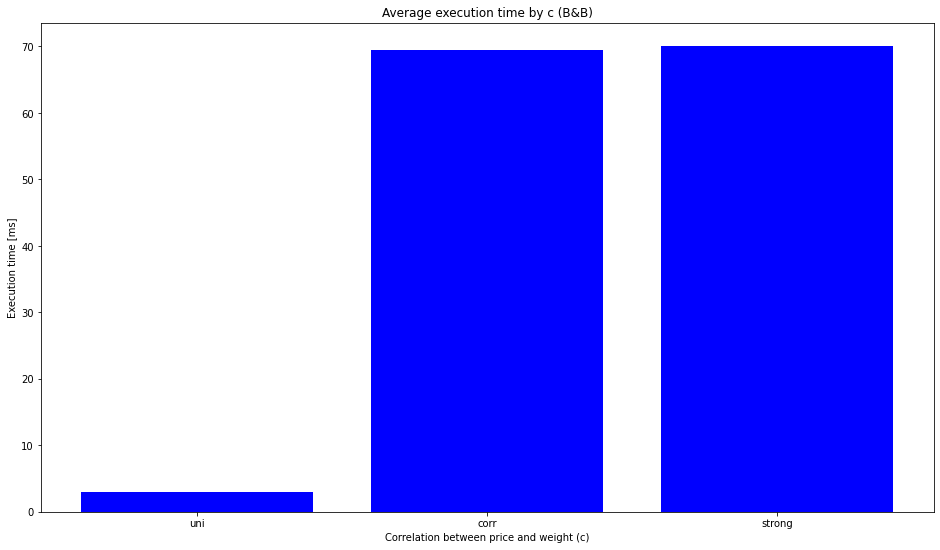

In [29]:
c_data = c_gen(gen_opts, "bb")
plt = c_graph(c_data, "B&B")
plt.show()

From the graph above, we can observe that the algorithm is fastest if there is no correlation between the price and weight of an item and the prices are uniformly distributed between the items up to the maximum price. The execution time rises if the correlation is stronger.

### 3.2.3 Weight Distribution and Granularity

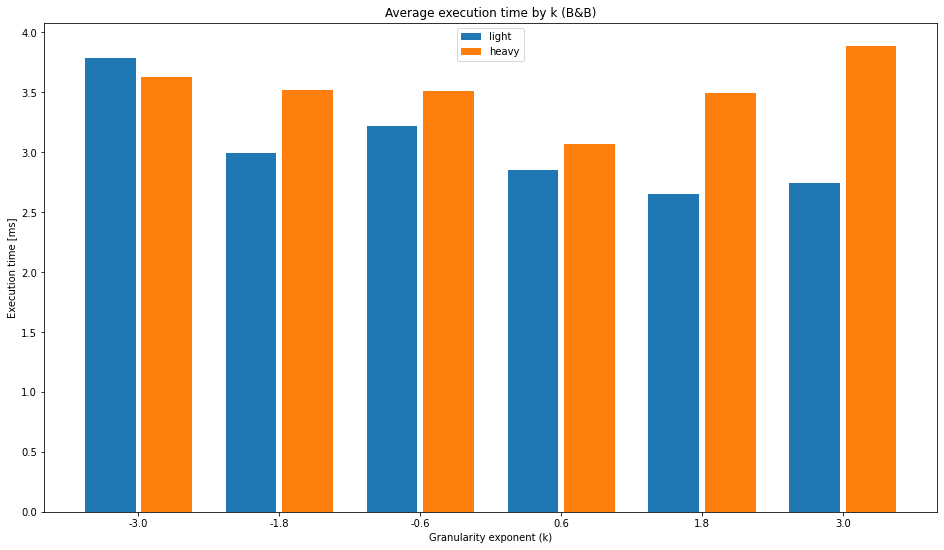

In [6]:
k_data = k_gen(gen_opts, "bb")
fig, ax = plt.subplots()
k_graph(k_data, ax, "B&B")

We can see that the execution time has a somewhat lowering trend for the light items majority when we increase the value of the exponent $k$. For the heavy items majority, the algorithm is a little bit faster when the value of the exponent is around $0$. Nevertheless, we do not observe a strong dependency of the **B&B** algorithm on the exponent $k$.

### 3.2.4 Robustness

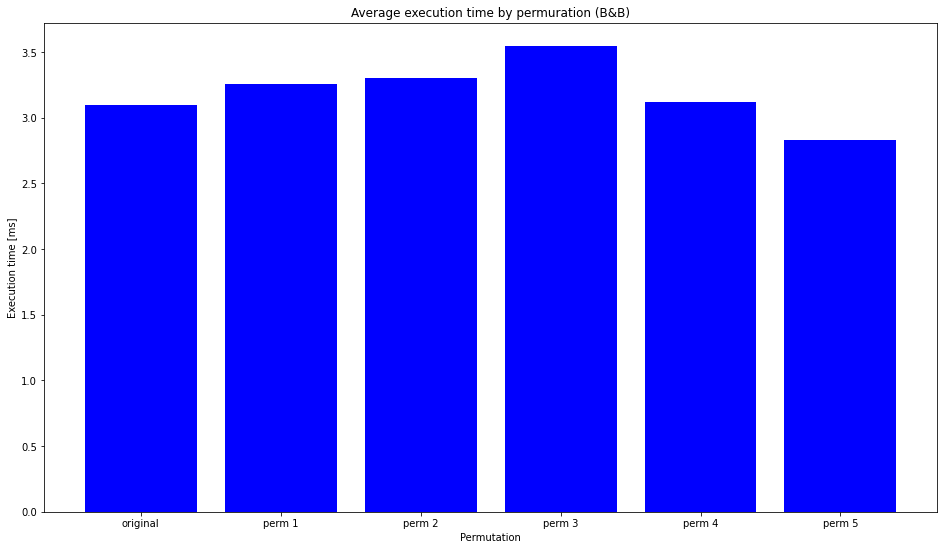

In [33]:
p_data = p_gen(gen_opts, "bb")
plt = p_graph(p_data, "B&B")
plt.show()

We can observe minor deviations between the average execution times between the permutation. However, these deviations are not very significant, and we can conclude that the **B&B** is quite a robust algorithm.

## 3.3 Greedy Heuristic

You can find a description of the algorithm in **section 2.3**.

### 3.3.1 Knapsack Capacity and Sum Weight Ratio

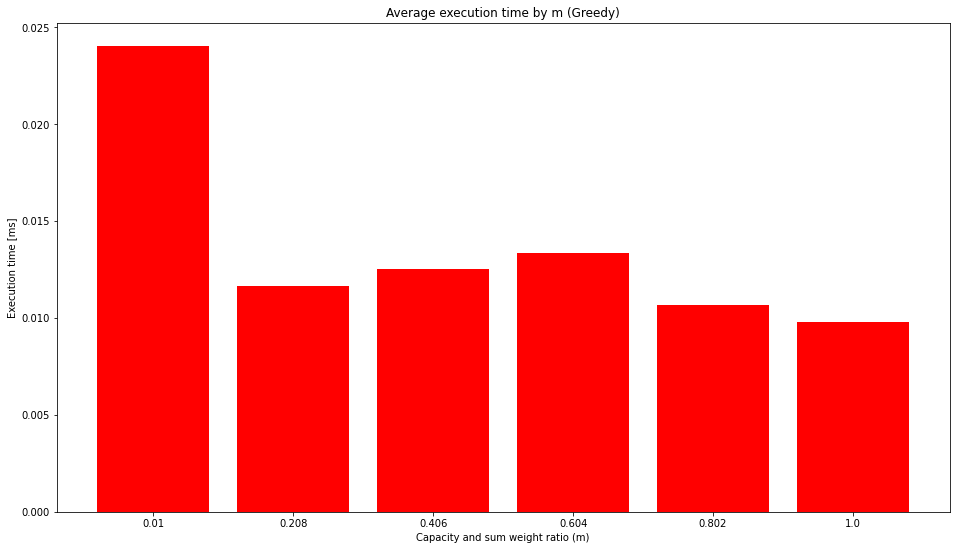

In [8]:
m_data, m_data_r = m_gen(gen_opts, "gh", rel_err=True)
plt = m_graph(m_data, "Greedy")
plt.show()

From the graph above, we can observe that the **greedy heuristic** algorithm is slower if the ratio is almost $0$. We can conclude that the algorithm is faster if there are more items that we can put to the knapsack without overloading it.

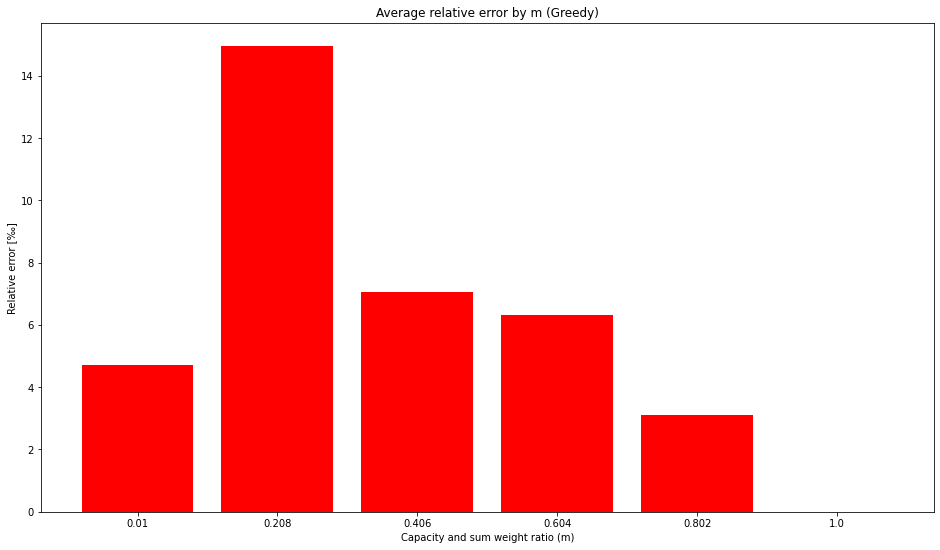

In [9]:
plt = m_graph(m_data_r, "Greedy", rel_err=True)
plt.show()

We can observe that there is a dependency between the ratio $m$ and the average relative error. The interesting fact is that the average relative error is $0$ if we can put all items into the knapsack. This fact relates to the way the algorithm works.

### 3.3.2 Price and Weight Correlation

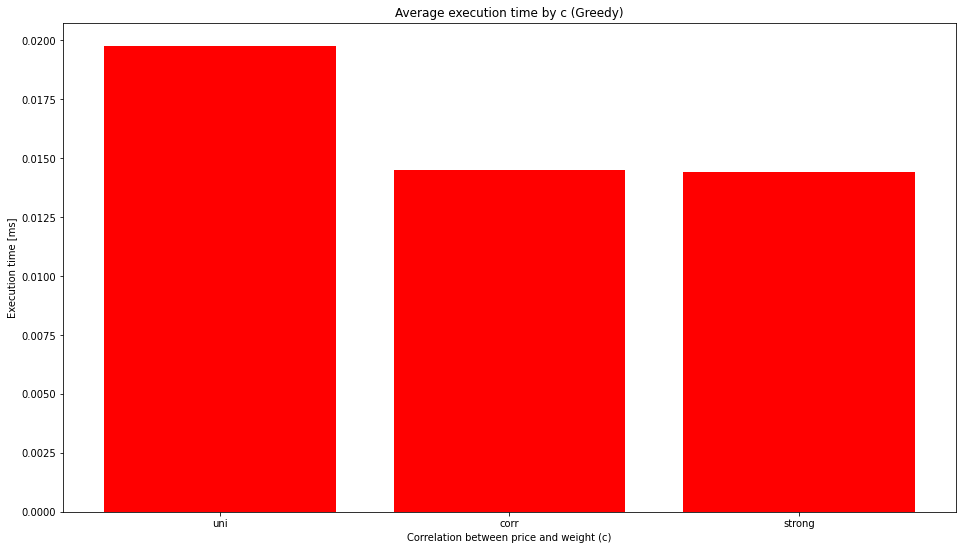

In [10]:
c_data, c_data_r = c_gen(gen_opts, "gh", rel_err=True)
plt = c_graph(c_data, "Greedy")
plt.show()

The algorithm is slightly faster if the correlation between the price and weight is stronger. Definitely, there is some dependency on the parameter $c$, which could be more significant for the larger instances.

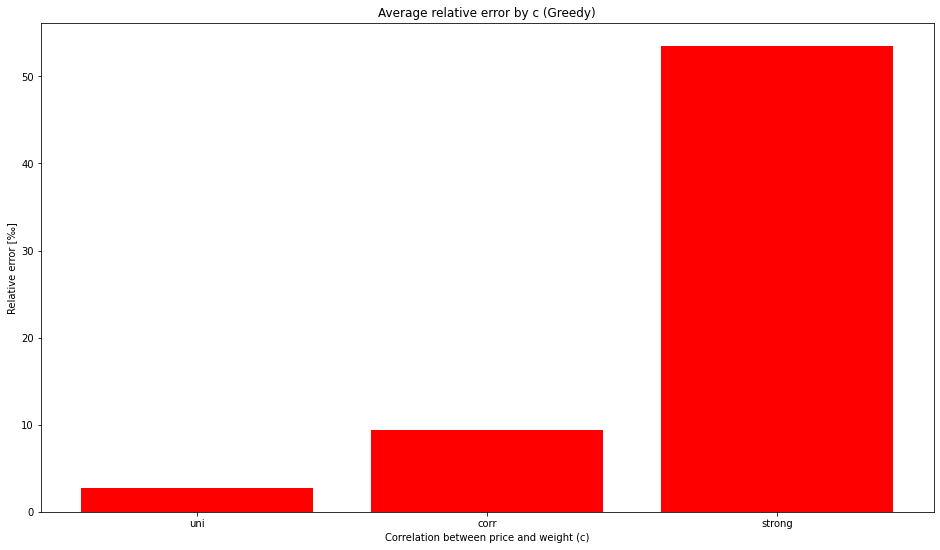

In [11]:
plt = c_graph(c_data_r, "Greedy", rel_err=True)
plt.show()

We can observe a strong dependency of the average relative error on the correlation between the price and weight. The algorithm is much more inefficient when the correlation is strong.

### 3.3.3 Weight Distribution and Granularity

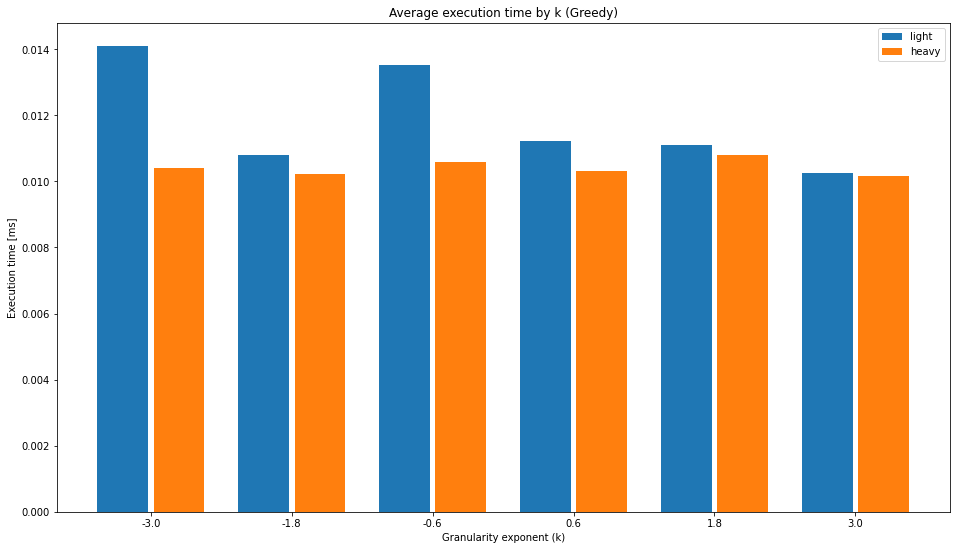

In [12]:
k_data, k_data_r = k_gen(gen_opts, "gh", rel_err=True)
fig, ax = plt.subplots()
k_graph(k_data, ax, "Greedy")

The **greedy heuristic** algorithms' execution time is relatively stable to changing exponent $k$ for the heavy items majority. We can see minor deviations for the light items majority. Nevertheless, these deviations are not very significant.

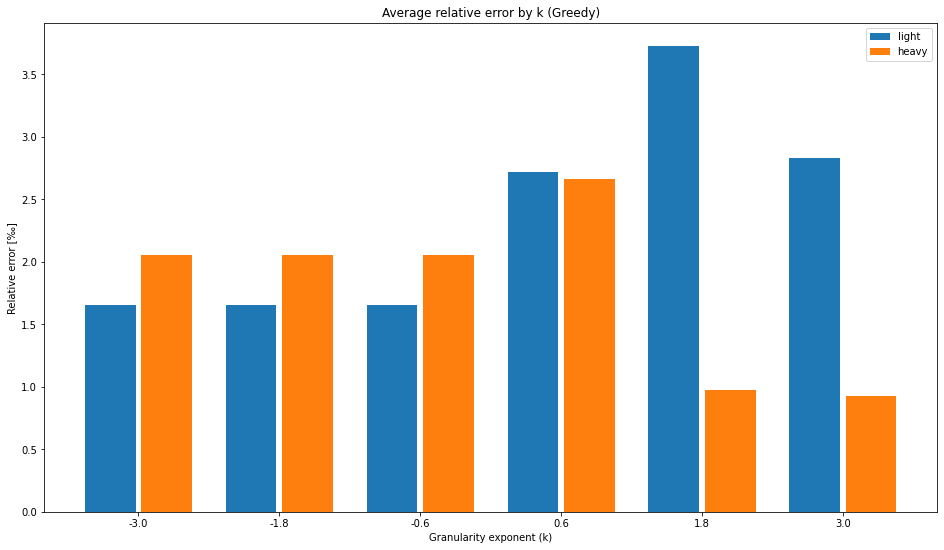

In [13]:
fig, ax = plt.subplots()
k_graph(k_data_r, ax, "Greedy", rel_err=True)

We can observe that the average relative error rises if we raise the exponent for the heavy items. The behavior is symmetric for the light items. We can observe a dependency between the relative error and the exponent $k$ for both light and heavy items.

### 3.3.4 Robustness

There is no need to observe the robustness since we always sort the items in the algorithm in the computation process.

## 3.4 Redux Heuristic

You can find a description of the algorithm in **section 2.4**.

### 3.4.1 Knapsack Capacity and Sum Weight Ratio

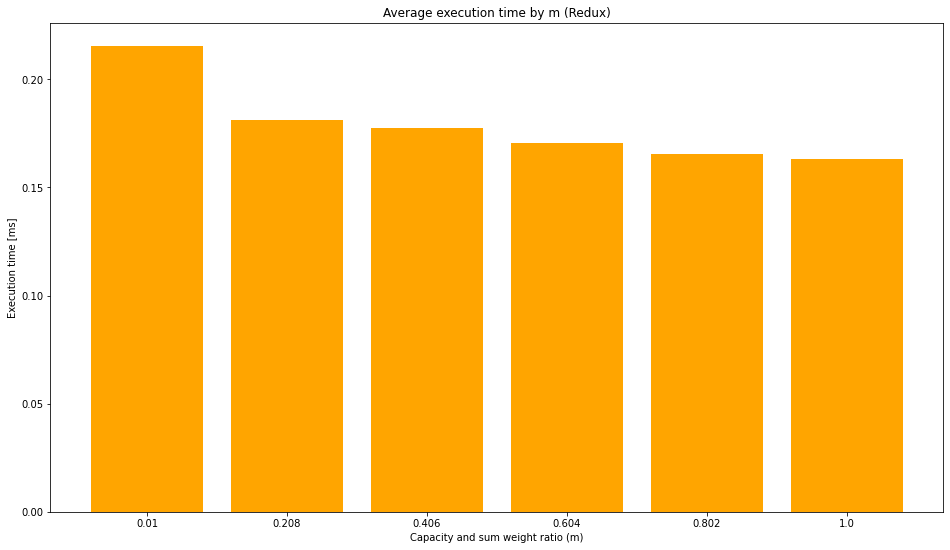

In [16]:
m_data, m_data_r = m_gen(gen_opts, "rgh", rel_err=True)
plt = m_graph(m_data, "Redux")
plt.show()

From the graph above, we can observe that the algorithm is faster if the ratio is higher. It is a similar behavior as we could see when we observed the **greedy heuristic** algorithm. However, the **redux heuristic** execution time is not that dependent on the ratio $m$.

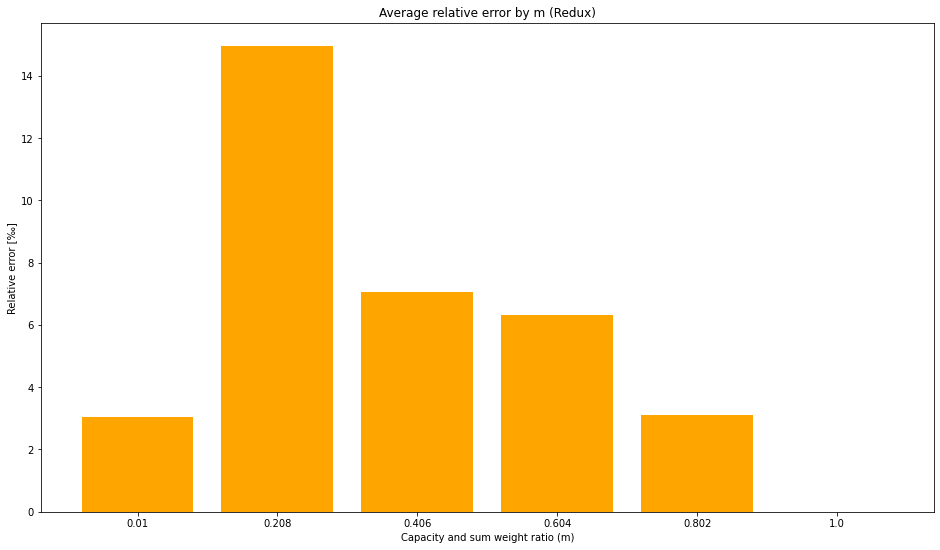

In [17]:
plt = m_graph(m_data_r, "Redux", rel_err=True)
plt.show()

We can observe almost identical relative error dependency on the ratio $m$ as we observed using the **greedy heuristic**. Again, the average relative error is $0$ for the **redux heuristic** if the ratio is $1$ and we can fit in all items.

### 3.4.2 Price and Weight Correlation

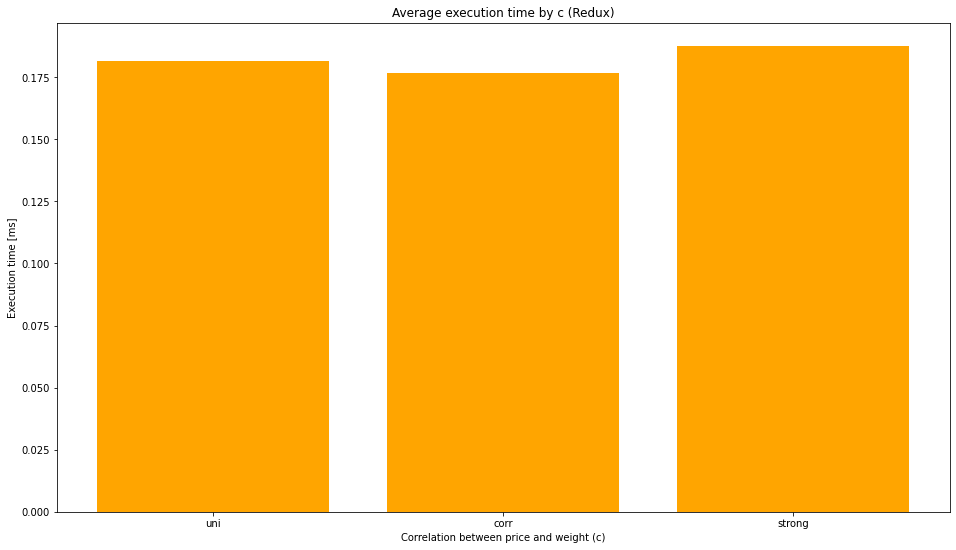

In [18]:
c_data, c_data_r = c_gen(gen_opts, "rgh", rel_err=True)
plt = c_graph(c_data, "Redux")
plt.show()

The **redux heuristic** execution time is not very sensitive to the correlation between the price and weight. The deviations between the correlations are almost negligible.

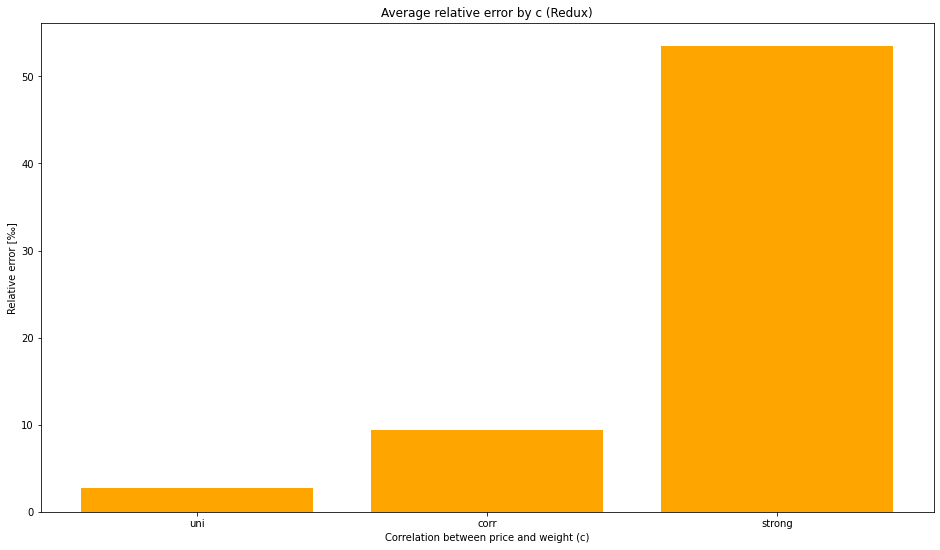

In [19]:
plt = c_graph(c_data_r, "Redux", rel_err=True)
plt.show()

On the other hand, we can see a strong dependency between the average relative error and the correlation between the price and weight. Like the **greedy heuristic**, the **redux** version is much more unreliable using the strong correlation.

### 3.4.3 Weight Distribution and Granularity

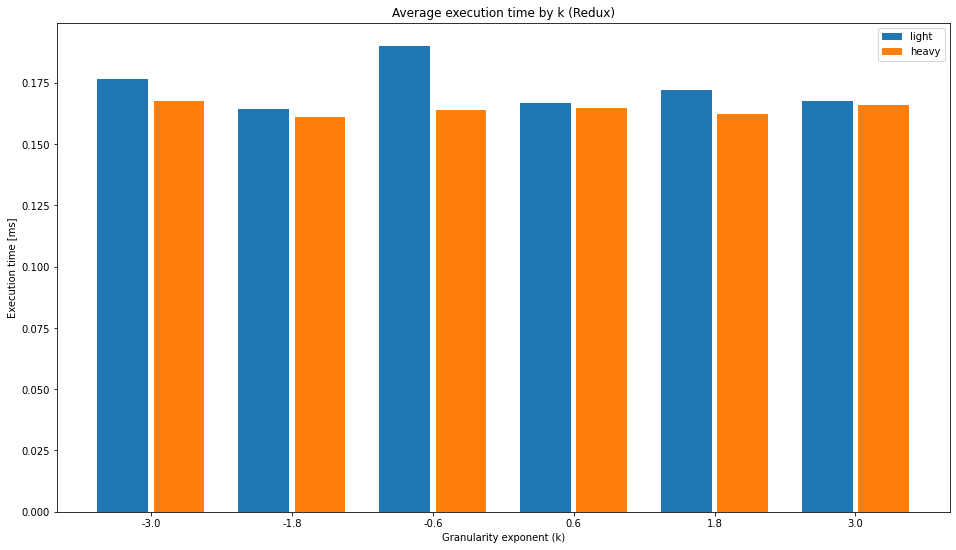

In [35]:
k_data, k_data_r = k_gen(gen_opts, "rgh", rel_err=True)
fig, ax = plt.subplots()
k_graph(k_data, ax, "Redux")

From the graph above, we can observe that the **redux heuristic** execution time is almost insensitive to the changing granularity exponent $k$. Since the **greedy** version is core part of the algorithm, the results are similar. 

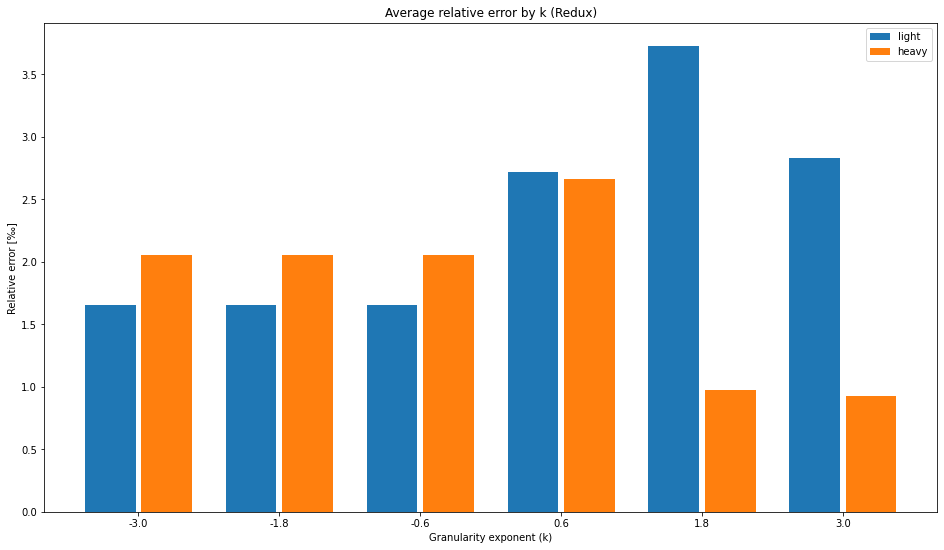

In [21]:
fig, ax = plt.subplots()
k_graph(k_data_r, ax, "Redux",rel_err=True)

In [ ]:
Simi

### 3.4.4 Robustness

There is no need to observe the robustness since we always sort the items in the algorithm in the computation process.

## 3.5 Dynamic Programming (Weight Decomposition)

`TODO`

### 3.5.1 Knapsack Capacity and Sum Weight Ratio

`TODO`

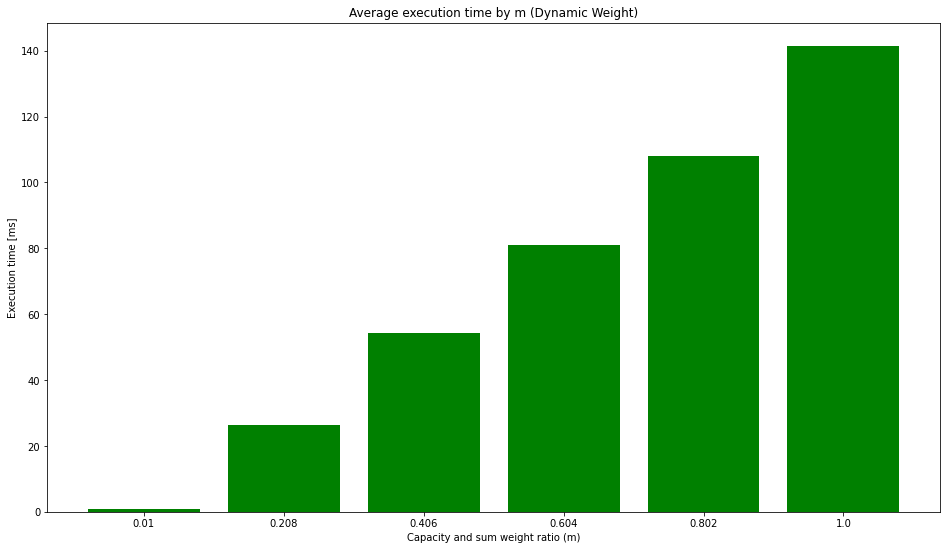

In [24]:
m_data = m_gen(gen_opts, "dw")
plt = m_graph(m_data, "Dynamic Weight")
plt.show()

### 3.5.2 Price and Weight Correlation

`TODO`

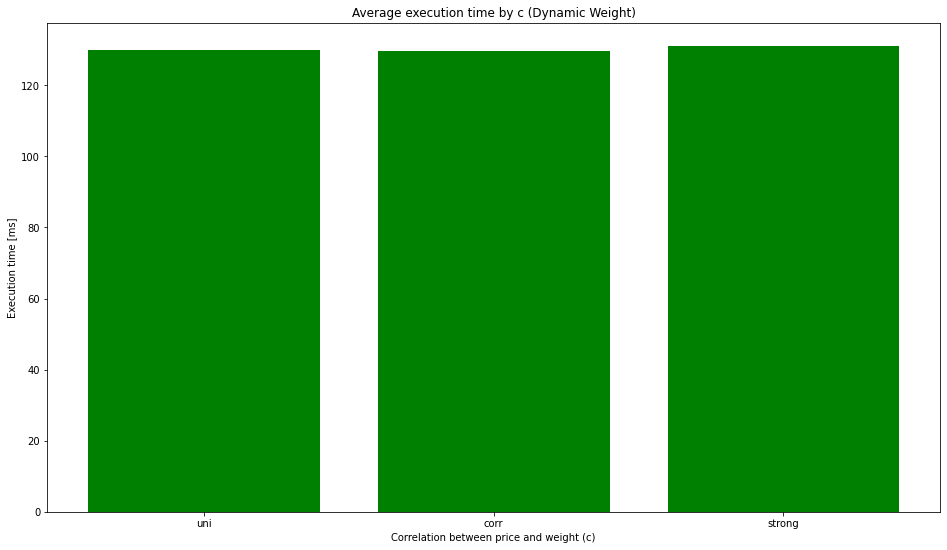

In [25]:
c_data = c_gen(gen_opts, "dw")
plt = c_graph(c_data, "Dynamic Weight")
plt.show()

### 3.5.3 Weight Distribution and Granularity

`TODO`

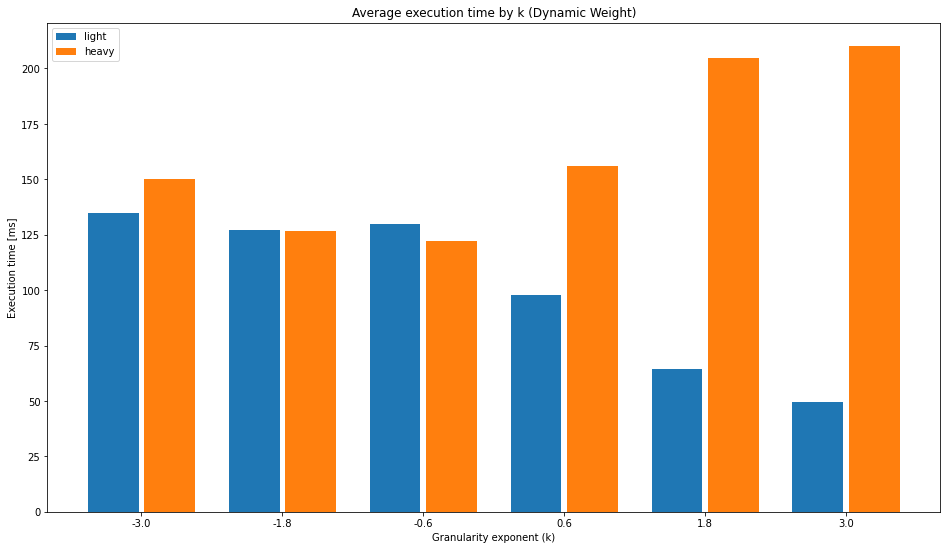

In [26]:
k_data = k_gen(gen_opts, "dw")
fig, ax = plt.subplots()
k_graph(k_data, ax, "Dynamic Weight")

### 3.5.4 Robustness

`TODO`

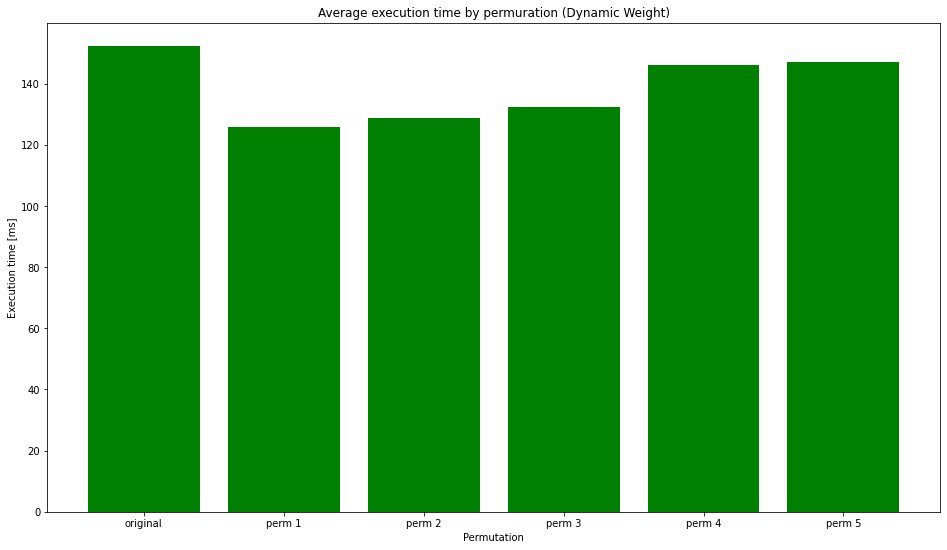

In [27]:
p_data = p_gen(gen_opts, "dw")
plt = p_graph(p_data, "Dynamic Weight")
plt.show()

# 4 Conclusion

`TODO`

# Bibliography

<br>

“B201-NI-KOP: Problém Batohu (Knapsack Problem).” 2020. Accessed November 20. [https://
moodle-vyuka.cvut.cz/mod/page/view.php?id=89694]().

“B201-NI-KOP: Generátory instancí problému batohu (Knapsack problem instance generators).” 2020. Accessed November 20. [https://moodle-vyuka.cvut.cz/mod/page/view.php?id=89701]()